In [230]:
import numpy as np
import matplotlib.pylab as plt
import scipy.signal as sig
plt.style.use(['classic','science'])

%matplotlib inline

plt.rcParams["figure.figsize"] = [6.4, 4.8]
%config InlineBackend.figure_format='retina'

# Question 1 
Define a shifting function.
We convolve the shifted delta distribution with the original function to achieve this goal. **Impulse shifting property**

In [231]:
def shift(arr, steps):
    Farr = np.fft.fft(arr)
    delta = np.zeros(len(arr))
    delta[steps] = 1
    Fdelta = np.fft.fft(delta)
    return np.fft.ifft(Fdelta * Farr)

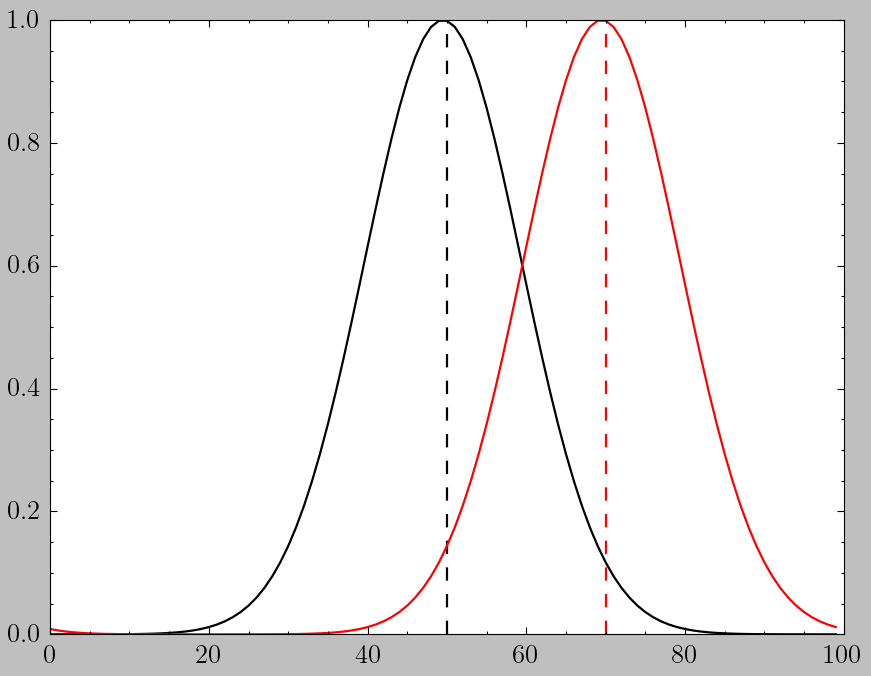

In [232]:
xx = np.linspace(-5,5,100)
yy = np.exp(-1/2*xx**2)

plt.plot(np.abs(yy), c='k')
plt.axvline(len(yy)//2, c='k', ls = '--')
plt.plot(np.abs(shift(yy,20)), c = 'r')
plt.axvline(len(yy)//2+20, c='r', ls = '--', label = "shifted")

# Question 2

In [233]:
def corr(a, b):
    return np.fft.ifft(np.fft.fft(a) * np.conj(np.fft.fft(b)))

## Notice that our correlation function is subject to boundary condition. Therefore, we get another symmetric piece across the Gaussian.
We can use fftshift to bring the center to zero.

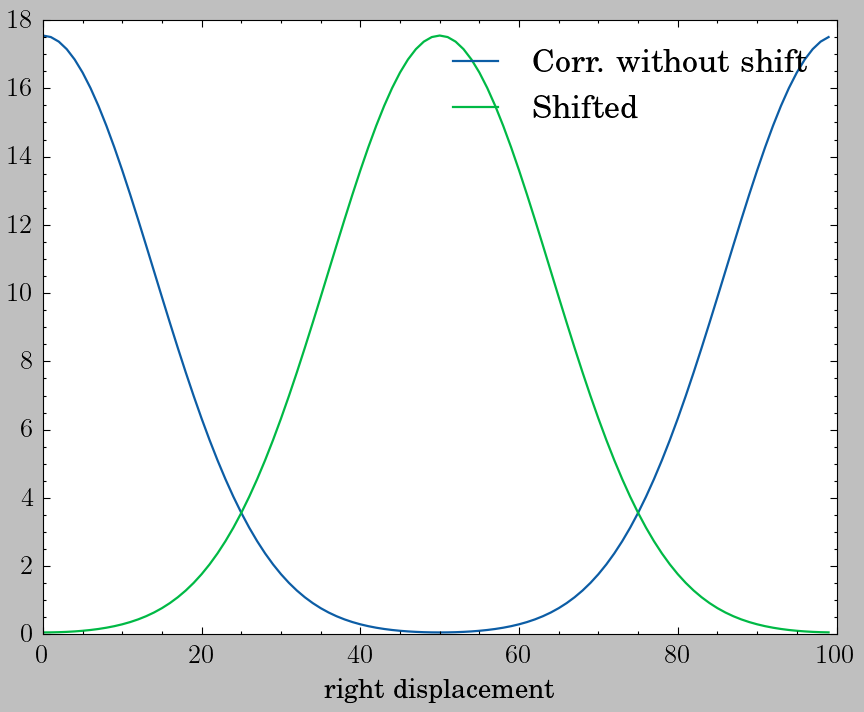

In [234]:
plt.plot(np.abs(corr(yy,yy)), label = 'Corr. without shift')
plt.plot(np.abs(np.fft.fftshift(corr(yy,yy))), label = 'Shifted')
plt.xlabel('right displacement')
plt.legend()

## Correlation between gaussian and shifted.

In [235]:
def s_corr(a, steps):
    return np.fft.ifft(np.fft.fft(a) *np.fft.fft(shift(a, steps)))

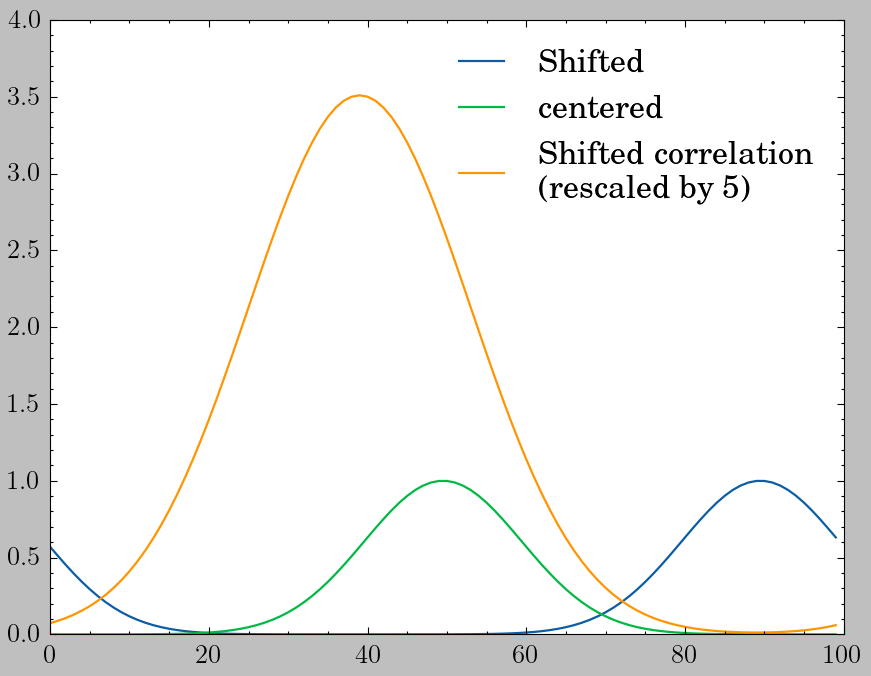

In [236]:
step = 40
plt.plot(np.abs(shift(yy,step)), label='Shifted')
plt.plot(np.abs(shift(yy,0)), label = 'centered')
plt.plot(np.abs(s_corr(yy, step))/5, label = 'Shifted correlation \n(rescaled by 5)')
plt.legend()

In general, the maximum amplitude of the correlation remains unchainged. \
**But the peak of the correlation function shifts by the same amount.**
This is no surprise. We get max overlap if we bring the shifted Gaussian back.

# Question 3

The total length of two signals with non-zero overlaps is at most **N+M-1**.\
If the two signals are of length N, M, we pad each of them with zeros at the end to length N+M-1. Then there is a buffer zone at the end for signal to NOT wrap around.


In [237]:
def conv(a, b):
    lena = len(a)
    lenb = len(b)
    
    a = np.pad(a, (0, lenb - 1))
    b = np.pad(b, (0, lena - 1))
    
    return np.fft.irfft(np.fft.rfft(a) * np.fft.rfft(b))


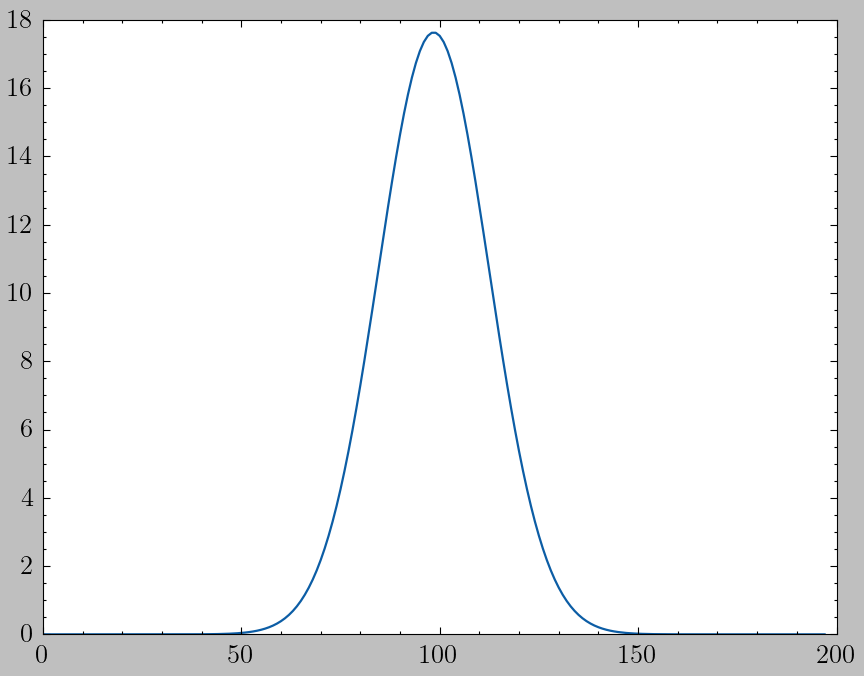

In [238]:
plt.plot(conv(yy,yy))

# Question 5  LIGO data
We analyze GW151226 as an example, followed up by looping over the other three events in similar style. 


In [239]:
import h5py
import glob 
import json

dat_fold = './LOSC_Event_tutorial/'
event_file = dat_fold + "BBH_events_v3.json"

In [240]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tp=template[0]
    tx=template[1]
    return tp,tx

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc


def smooth_vector(vec,sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

In [241]:
event_codes = json.load(open(event_file, "r")).keys()
event_codes

dict_keys(['GW150914', 'LVT151012', 'GW151226', 'GW170104'])

In [242]:
event = json.load(open(event_file, "r"))["GW150914"]

sL, dtL, utcL = read_file(dat_fold + event['fn_L1'])
sH, dtH, utcH = read_file(dat_fold + event['fn_H1'])
tp, tx = read_template(dat_fold + event['fn_template'])

# Frequency space x-axis
The time steps between Livingston and Hanford data are the same.
Because of the inverse proportionality between dt and df, we can calculate our frequencies.

In [243]:
time = dtL *len(sH)
df = 1/time
f = np.arange(len(sL))*df
f[0]=0.5*f[1]
t = dtL * np.arange(len(sH))

# Power spectrum without windowing and smoothing

In [244]:
PSsL = np.abs(np.fft.fft(sL))**2
PSsH = np.abs(np.fft.fft(sH))**2
PStp = np.abs(np.fft.fft(tp))**2

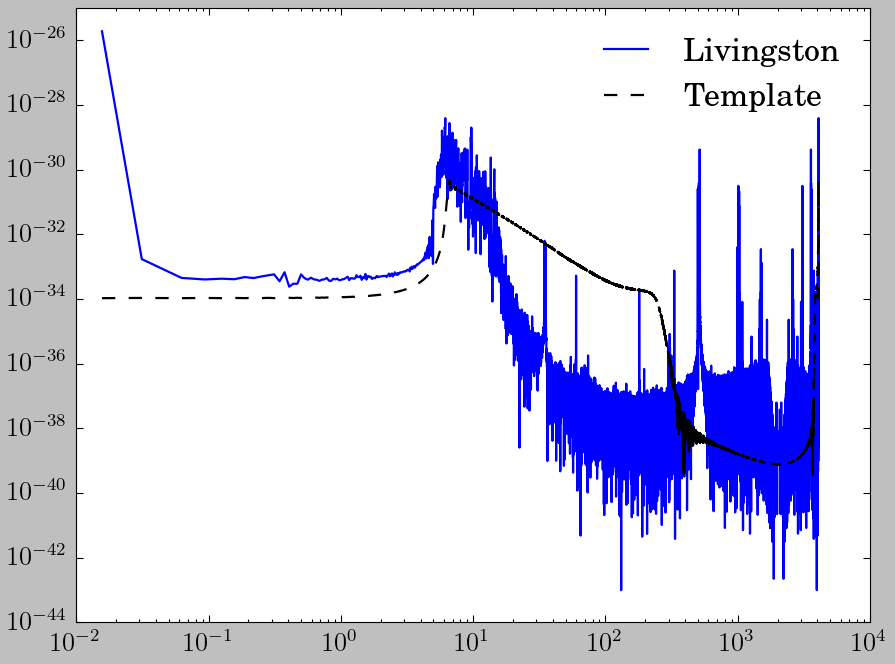

In [245]:
plt.loglog(f, PSsL, c='b', label = 'Livingston')
plt.loglog(f, PStp, c='k', ls = '--', label = 'Template')
plt.legend()

# Choice of window function
Here we use Tukey window funtion since it has a flat top so it doesn't taper the data.

(0.0, 131072.0, 0.0, 1.2)

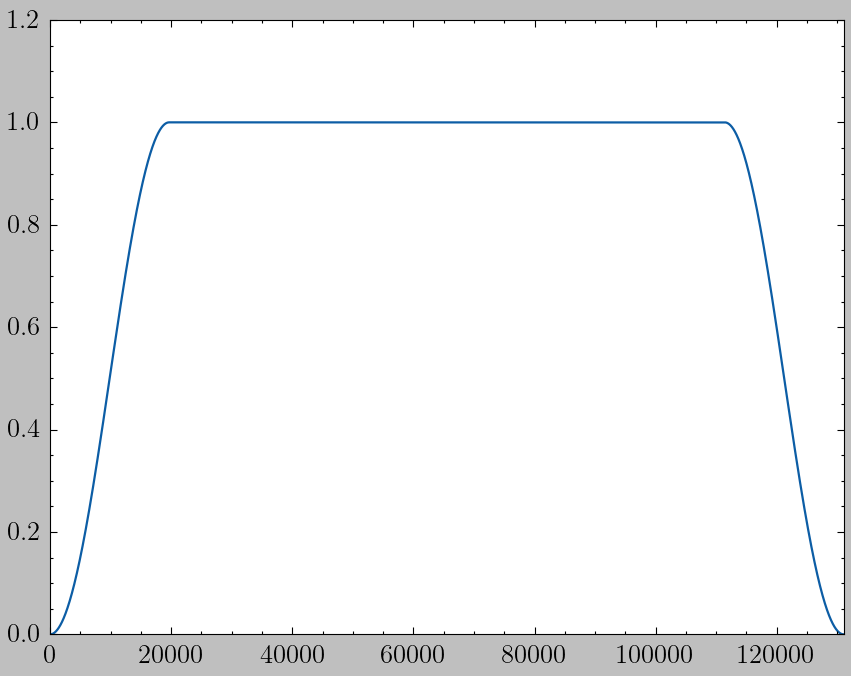

In [246]:
win = sig.tukey(len(tp), alpha = .3)
plt.plot(win)
plt.axis([0, len(tp), 0,1.2])

# Power spectrum Smoothing
We used a Gaussian with width of ten similar to what Jon did in class. Borrowing his code, which convolves a given spectrum with a Gaussian...

The whitening step will convolve the power spectrum with a Gaussian filter, make it less fluctuating. 

This also gets rid of spectral features, and we can use the frequency independent part as our noise spectrum.

In [247]:
width = 30
# strain
PSsL_win = np.abs(np.fft.fft(sL * win)**2)
PSsL_smooth = smooth_vector(PSsL_win, width)


PSsH_win = np.abs(np.fft.fft(sH * win)**2)
PSsH_smooth = smooth_vector(PSsH_win, width)

# template
PStp_win = np.abs(np.fft.fft(tp * win)**2)
PStp_smooth = smooth_vector(PStp_win, width)


# Let's have a look at the windowed P.S.. We will infer our noise from this.
The instrument has a digital filter at $1650$ Hz. Hence we want to reference this threshold when setting the noise matrix.


# Noise Models

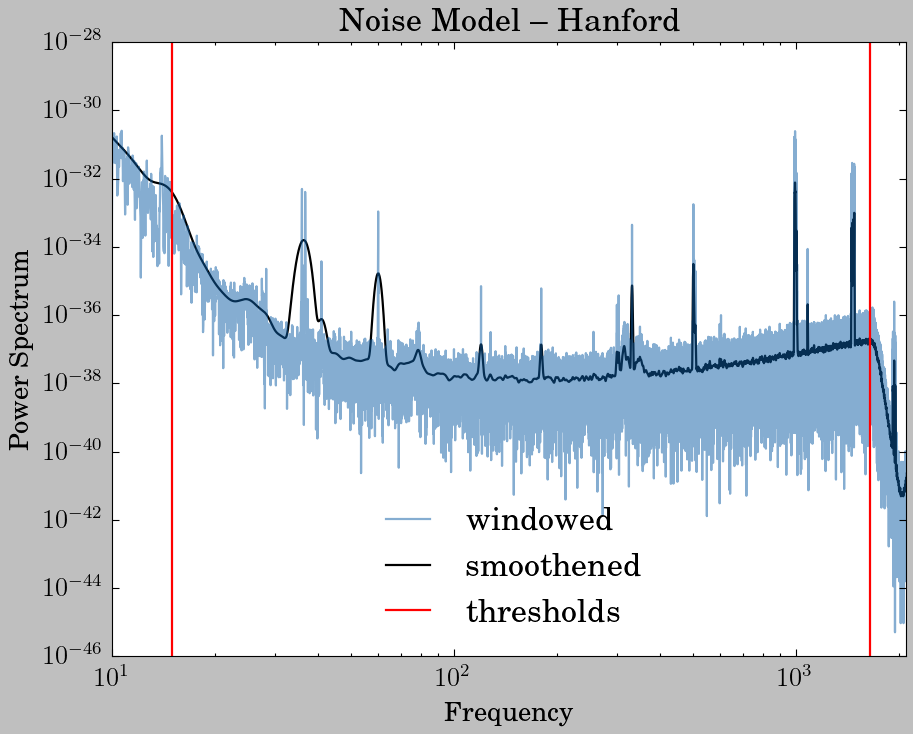

In [248]:
plt.loglog(f, PSsH_win, alpha = .5, label = 'windowed')
plt.loglog(f, PSsH_smooth, c='k', zorder = 1,  label = 'smoothened')
plt.axvline(15,c='r', label = 'thresholds')
plt.axvline(1650, c ='r')
plt.xlim([10,2100])


plt.ylabel("Power Spectrum")
plt.xlabel('Frequency')
plt.title('Noise Model -- Hanford')
plt.legend(loc = 8)


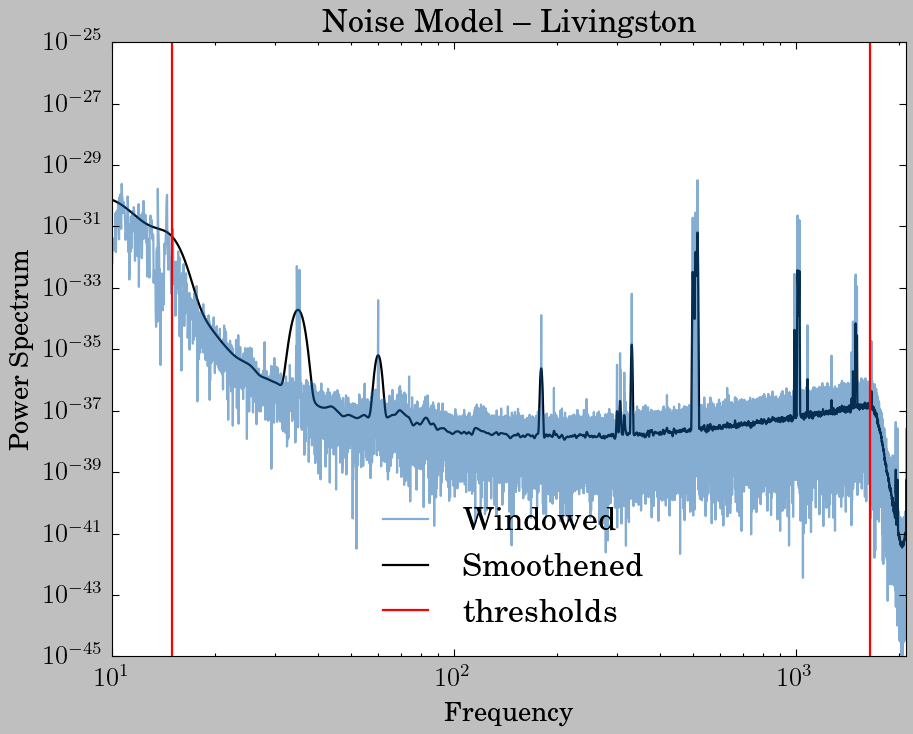

In [249]:
plt.loglog(f, PSsL_win, alpha = .5, label = 'Windowed')
plt.loglog(f, PSsL_smooth, c='k', zorder = 1,  label = 'Smoothened')
plt.axvline(15,c='r', label = 'thresholds')
plt.axvline(1650, c ='r')
plt.xlim([10,2100])

plt.ylabel("Power Spectrum")
plt.xlabel('Frequency')
plt.title('Noise Model -- Livingston')
plt.legend(loc = 8)

# Inverse matrix conditioning
Setting entries of the ``Ninv`` matrix to zero is equivalent to downweighting the frequencies corresponding to these entries. \
The greater the uncertainties, the smaller Ninv is.

The left cutoff is due to blow up towards low frequency.
The right cutoff is due tot he digital instrumental filter.

In [250]:
NL_inv = 1/PSsL_smooth
NH_inv = 1/PSsH_smooth

NH_inv[f>1650] = 0
NL_inv[f>1650] = 0

NH_inv[f<15] = 0
NL_inv[f<15] = 0

# Matched Filtering
Matched filter is done via $$m = (A^T N^{-1}A)^{-1}(A^T N^{-1}d)$$. The pre-whitening process requires us to split the noise matrix into $N^{-\frac{1}{2}}$ in the numerators. Following this process, the matched filter (right hand side) becomes $$(N^{-\frac{1}{2}}A)^T(N^{-\frac{1}{2}}d)$$ (discarding the normalization term). \
This can be done in Fourier spacewhere using windowed data and windowed template (according to Jon's notes on M.F.).

Text(0, 0.5, 'Matched filter')

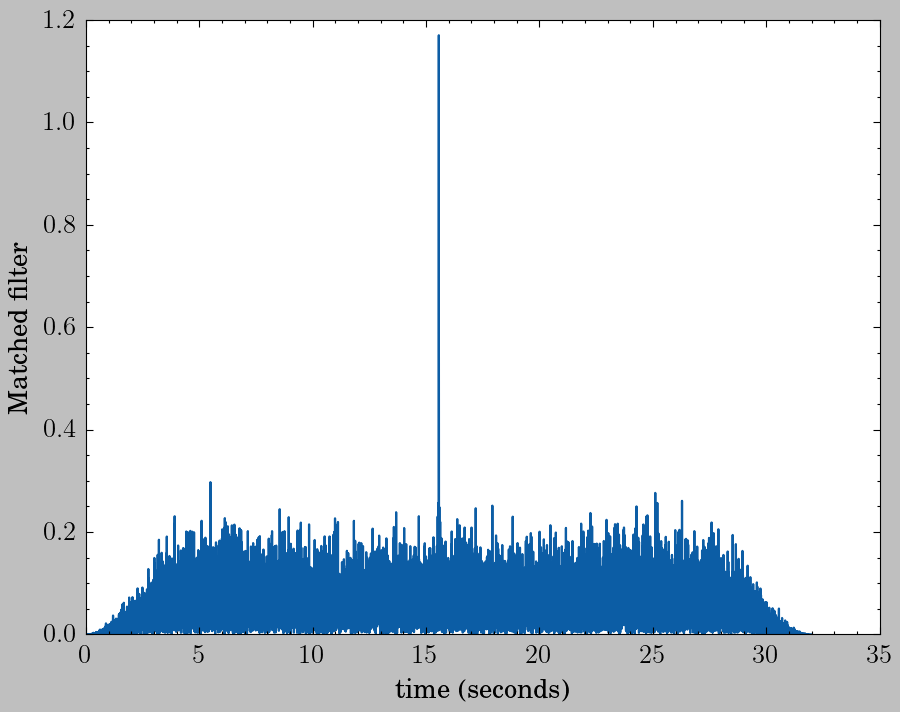

In [251]:
FH_white = np.sqrt(NH_inv)* np.fft.fft(sH*win)
FL_white = np.sqrt(NL_inv)* np.fft.fft(sL*win)
FL_tp_white = np.sqrt(NL_inv)*np.fft.fft(tp*win) 
FH_tp_white = np.sqrt(NH_inv)*np.fft.fft(tp*win) 

sigL = np.fft.ifft(FL_tp_white * np.conj(FL_white))

sigH = np.fft.ifft(FH_tp_white * np.conj(FH_white))

plt.plot(t,np.abs(np.fft.fftshift(sigH)), label = 'Hanford')
plt.xlabel("time (seconds)")
plt.ylabel("Matched filter")

# Signal to Noise ratio
The signal is our MF result (1D array). The noise is the covariance  $$(A^T N^{-1} A)^{-1} = N^{-1}A^2 = H^{-1}$$, which is just the inverse of Hessian matrix (curvature) and **Noramlization of the M.F.**. This is equivalent to **auto-correlation of the pre-whitened version of the template**.

Note that variance is additive for independent measurements while standard deviation is not.


In [252]:
varL = np.abs(np.fft.ifft(FL_tp_white * FL_tp_white.conjugate()))
varH = np.abs(np.fft.ifft(FH_tp_white * FH_tp_white.conjugate()))

noiseL = np.mean(np.sqrt(varL))
noiseH = np.mean(np.sqrt(varH))
noiseC = np.sqrt(noiseL**2+noiseH**2)

print("Noise for Livingston detector: ".ljust(30), noiseL)
print("Noise for Livingston detector: ".ljust(30), noiseH)
print("Combined noise: ".ljust(30), noiseC)

Noise for Livingston detector:  0.11946417036983117
Noise for Livingston detector:  0.1537860148136391
Combined noise:                0.19473527249682548


# SNR
Similar to $\chi^2$, the ratio of $E[X]^2$ and $\sigma_{X}^2$ is additive for independent events. We can sum up $\textbf{SNR}^2$.

For the normalization, since we have enough data,  the signaled domain is relatively short, and the window is wide, we can just take the standard deviaton across our M.F. to get a rough normalization estimate.

Max SNR for Livingston detector:  10.746929409886919
Max SNR for Livingston detector:  14.468889831600736
Combined SNR:                  18.023464281322045


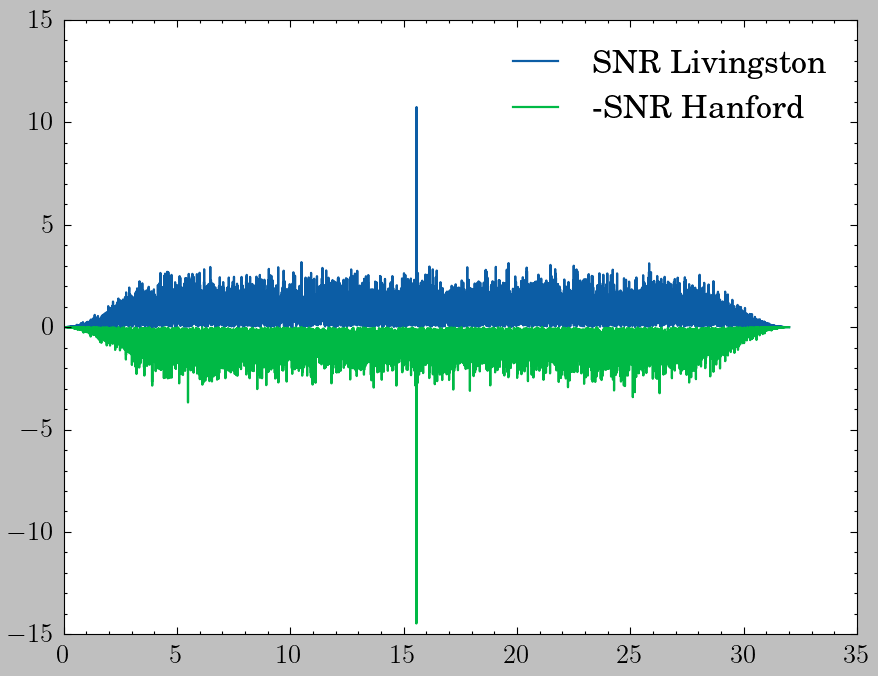

In [253]:
normH = np.std(sigH[200:-200])
normL = np.std(sigL[200:-200])

snrH = np.fft.fftshift(np.abs(sigH/normH))
snrL = np.fft.fftshift(np.abs(sigL/normL))
# They can appear at different time
snrC = np.sqrt(snrH.max()**2 + snrL.max()**2)

print("Max SNR for Livingston detector: ".ljust(30), snrL.max())
print("Max SNR for Livingston detector: ".ljust(30), snrH.max())
print("Combined SNR: ".ljust(30), snrC)
plt.plot(t, snrL, label = "SNR Livingston")
plt.plot(t, -snrH, label = "-SNR Hanford")
plt.legend()

# Analytic SNR vs. SNR

---------------------------------------- analytical ----------------------------------------
Max Analytical SNR for Livingston detector:        6.525279718941973
Max Analytical SNR for Hanford detector:           7.610173745774942
Combined Analytical SNR:                           10.024670560737528
---------------------------------------- computed ----------------------------------------
Max SNR for Livingston detector:                   10.746929409886919
Max SNR for Livingston detector:                   14.468889831600736
Combined SNR:                                      18.023464281322045
---------------------------------------- ratio ----------------------------------------
Analytic vs. Numerical -- Livingston:              0.6071761961085248
Analytic vs. Numerical -- Hanford:                 0.5259680482986306
Analytic vs. Numerical -- Combined SNR:            0.5562010945435294


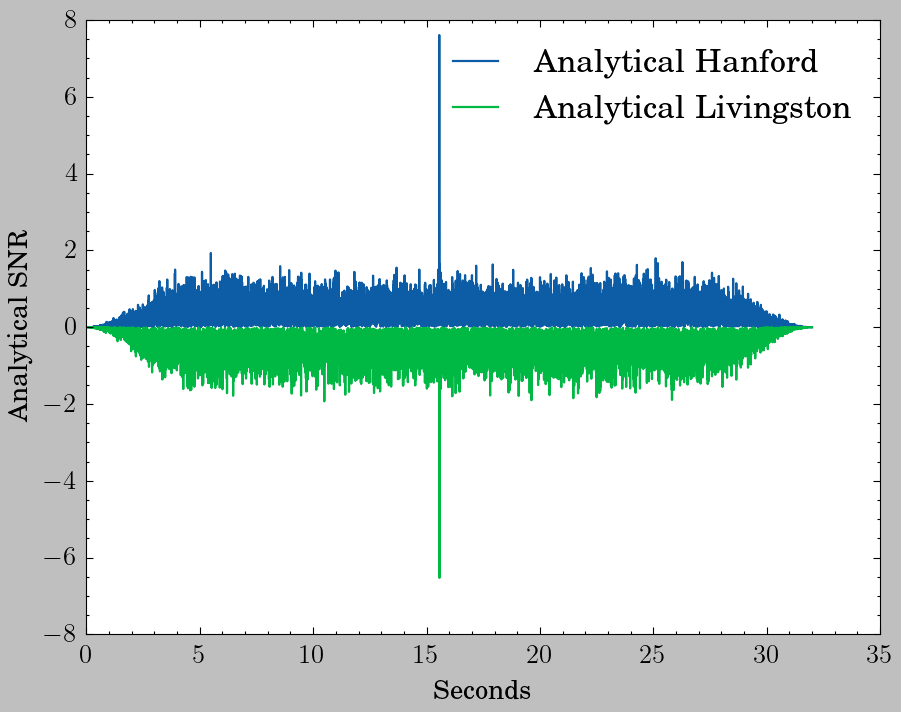

In [254]:
AsnrH = np.fft.fftshift(np.abs(sigH/noiseH))
AsnrL = np.fft.fftshift(np.abs(sigL/noiseL))
AsnrC = np.sqrt(AsnrH.max()**2 + AsnrL.max()**2)

print("--"*20, "analytical", "--"*20)
print("Max Analytical SNR for Livingston detector: ".ljust(50), AsnrL.max())
print("Max Analytical SNR for Hanford detector: ".ljust(50), AsnrH.max())
print("Combined Analytical SNR: ".ljust(50), AsnrC)

print("--"*20, "computed", "--"*20)
print("Max SNR for Livingston detector: ".ljust(50), snrL.max())
print("Max SNR for Livingston detector: ".ljust(50), snrH.max())
print("Combined SNR: ".ljust(50), snrC)

print("--"*20, "ratio", "--"*20)
print("Analytic vs. Numerical -- Livingston: ".ljust(50), AsnrL.max()/snrL.max())
print("Analytic vs. Numerical -- Hanford: ".ljust(50), AsnrH.max()/snrH.max())
print("Analytic vs. Numerical -- Combined SNR: ".ljust(50), AsnrC/ snrC)
plt.plot(t, AsnrH, label = 'Analytical Hanford')
plt.plot(t, -AsnrL, label = 'Analytical Livingston')
plt.xlabel("Seconds")
plt.ylabel("Analytical SNR")
plt.legend()

# Comparison 
The analytical SNR is, in general, smaller compared to our numerical SNR obtained by directly dividing by the variance. 
This can be because our noise model is not exact in terms of amplitude, and $\sqrt{(A^TN^{-1}A)}$ becomes larger.

Maybe Gaussian filter is not the best way to smoothen out the power spectrum.

# Half cumulative amplitude Frequency

In [255]:
idx_half = np.argwhere(np.cumsum(np.abs(FH_tp_white))/np.sum(np.abs(FH_tp_white))>.5).flatten().min()
print("Half-intensity frequency is:".ljust(30), f"{f[idx_half]:.0f}", "Hz")

Half-intensity frequency is:   134 Hz


Text(0, 0.5, 'Normalized Cumulative amplitude')

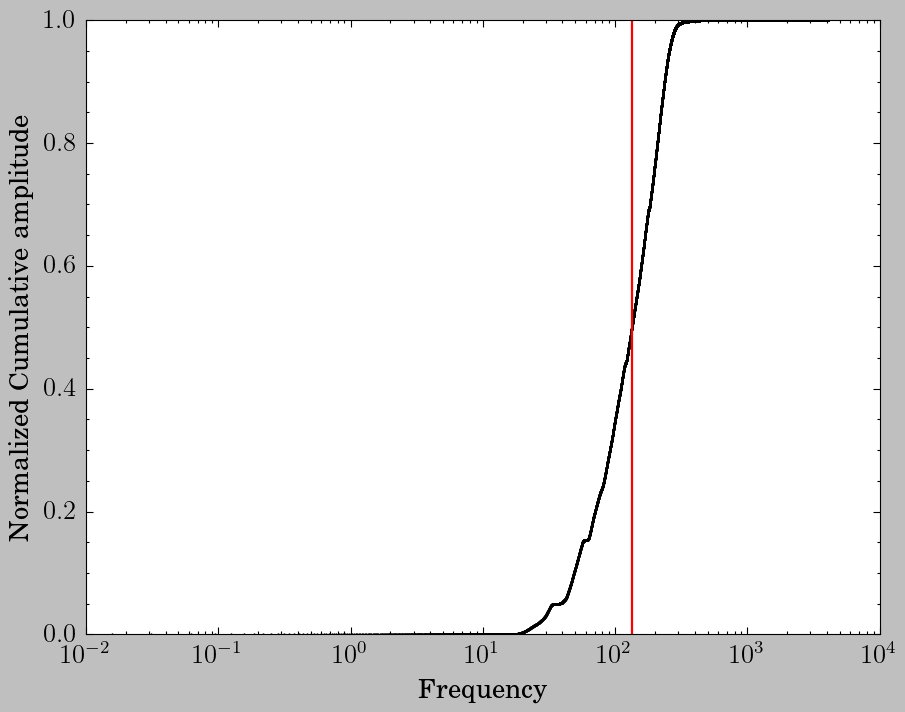

In [256]:
plt.plot(f, np.cumsum(np.abs(FH_tp_white))/np.sum(np.abs(FH_tp_white)), 'k.', ms = 1)
plt.axvline(f[idx_half], c = 'r', label = 'half-amp. freq.')
plt.xscale('log')
plt.xlabel('Frequency')
plt.ylabel('Normalized Cumulative amplitude')

# Time Comparison
For the uncertainty, we use interval within which SNR decreases by $1$.

Time difference is :           7.1 +/- 1.2 ms


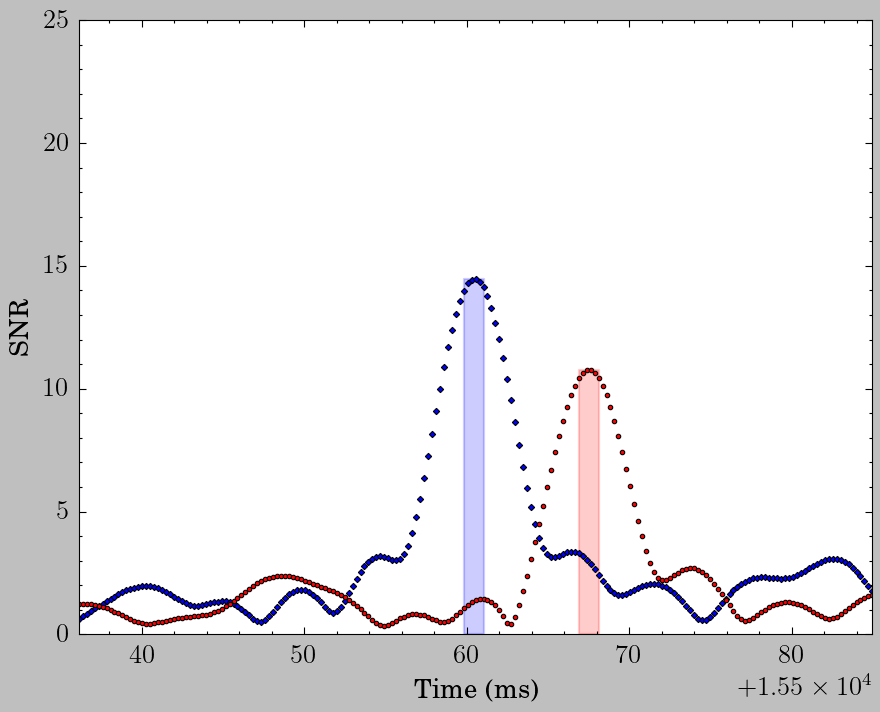

In [257]:
plt.plot(t*1e3, snrH,'bD', ms = 2 , label = "Livingston")
plt.plot(t*1e3, snrL,'ro', ms =2 , label = 'Hanford')

tmaxH = t[np.argmax(snrH)]
tmaxL = t[np.argmax(snrL)]

binH = np.argwhere(np.abs(snrH - snrH.max())<1)
binL = np.argwhere(np.abs(snrL - snrL.max())<1)

tleftH = t[np.min(binH)]
trightH = t[np.max(binH)]
tleftL = t[np.min(binL)]
trightL = t[np.max(binL)]

etH = (trightH-tleftH)/2
etL = (trightL-tleftL)/2

edt = np.sqrt(etH**2 + etL**2)
dt = np.abs(tmaxH - tmaxL)

plt.axis([(tmaxH-100*dtH)*1e3, (tmaxH+100*dtH)*1e3, 0,25])
plt.fill_between(t*1e3 , 0, snrH.max(),where=(t<trightH) & (t>tleftH) ,color='b', alpha = .2)
plt.fill_between(t*1e3 , 0, snrL.max(),where=(t<trightL) & (t>tleftL) ,color='r', alpha = .2)
plt.xlabel("Time (ms)")
plt.ylabel("SNR")

print("Time difference is :".ljust(30), f"{dt*1e3:.1f} +/- {edt*1e3:.1f} ms")

Distance between Hanford and Livingston (LHO and LLO) is 3002 km (source: https://www.ligo.caltech.edu/page/ligo-detectors).\
If GW propagates parallelly to our plane of detection, and strikes the two detectors at maximal time difference, the time difference we expect is $\Delta t = \text{distance}/\text{speed of light}$.

In [258]:
Adt = 3002*1e3/3/1e8
print("We expect time difference of: ", f"{Adt*1000:.3f} ms \
if GW propagates parallelly to our plane of detection.")

We expect time difference of:  10.007 ms if GW propagates parallelly to our plane of detection.


# For the other three events, we simply loop over them below.
The waves seem to be travelling almost perpendicular for all these three, as indicated by the relatively short $\Delta t$.

In [259]:
event_codes = json.load(open(event_file, "r")).keys()

-------------------- EVENT LVT151012 --------------------
Noise for Livingston detector:  0.08346468304013799
Noise for Livingston detector:  0.12277159874020832
Combined noise:                0.14845611732837896
Max SNR for Livingston detector:  4.551292486553042
Max SNR for Livingston detector:  5.396140980683283
Combined SNR:                  7.059220975544236
---------------------------------------- analytical ----------------------------------------
Max Analytical SNR for Livingston detector:        2.7454784722302477
Max Analytical SNR for Hanford detector:           2.248612634855601
Combined Analytical SNR:                           3.5487900505823085
---------------------------------------- computed ----------------------------------------
Max SNR for Livingston detector:                   4.551292486553042
Max SNR for Livingston detector:                   5.396140980683283
Combined SNR:                                      7.059220975544236
----------------------------------

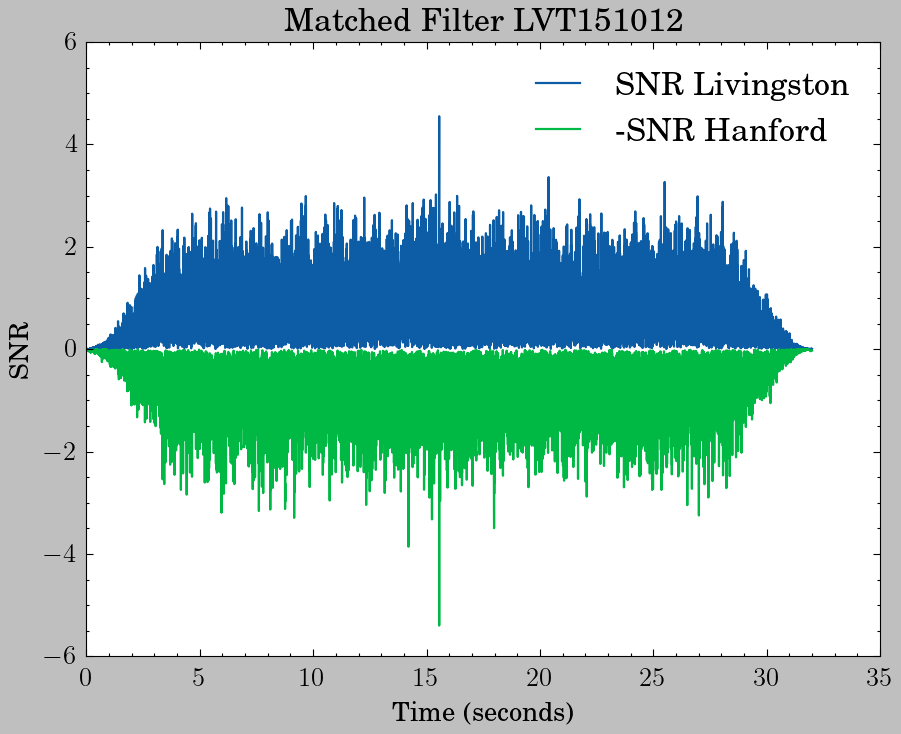

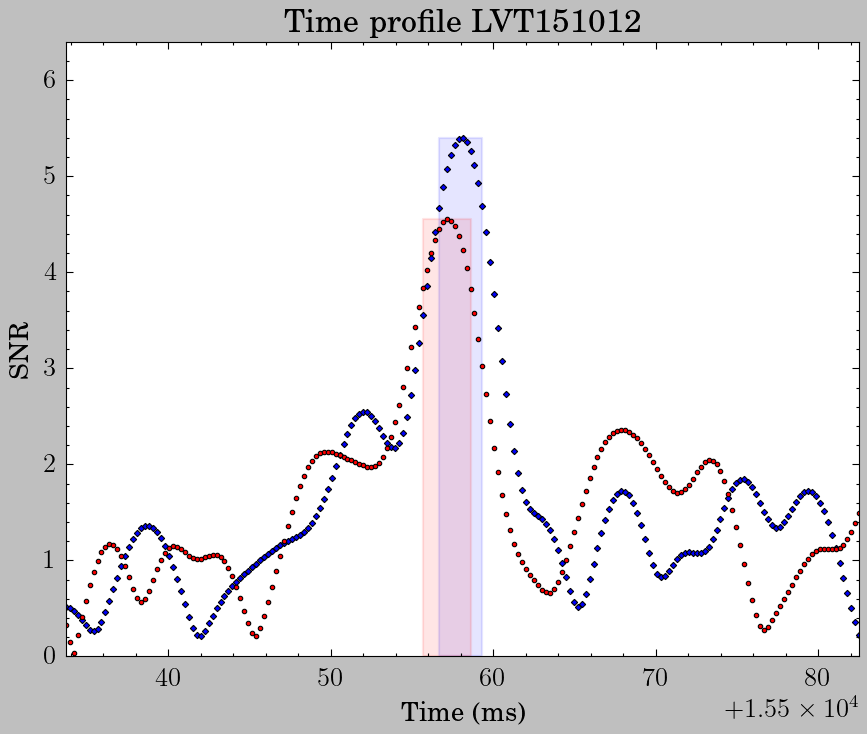

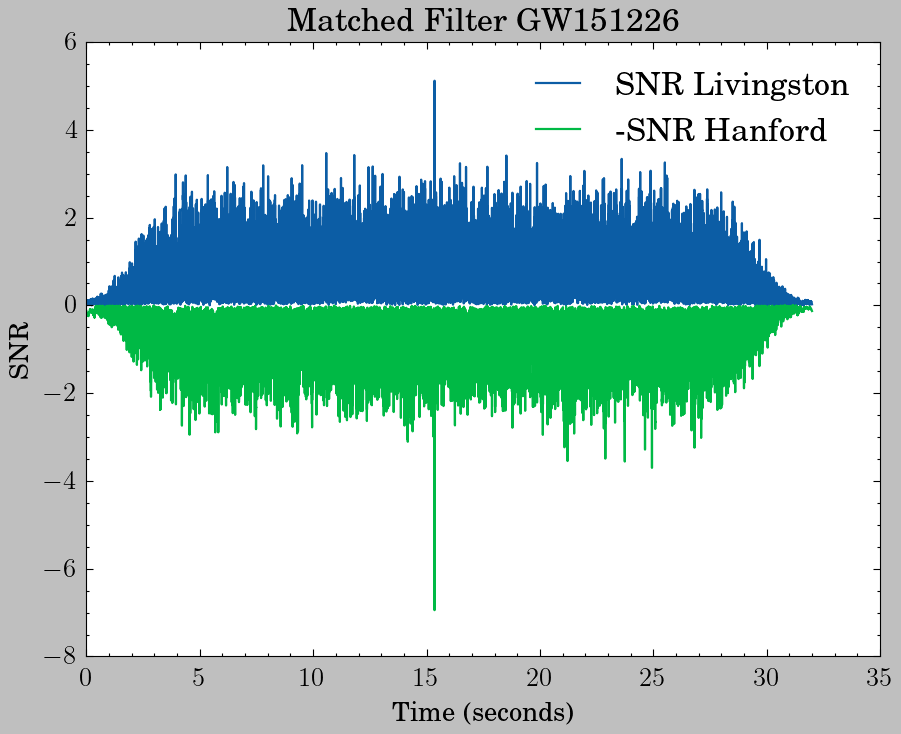

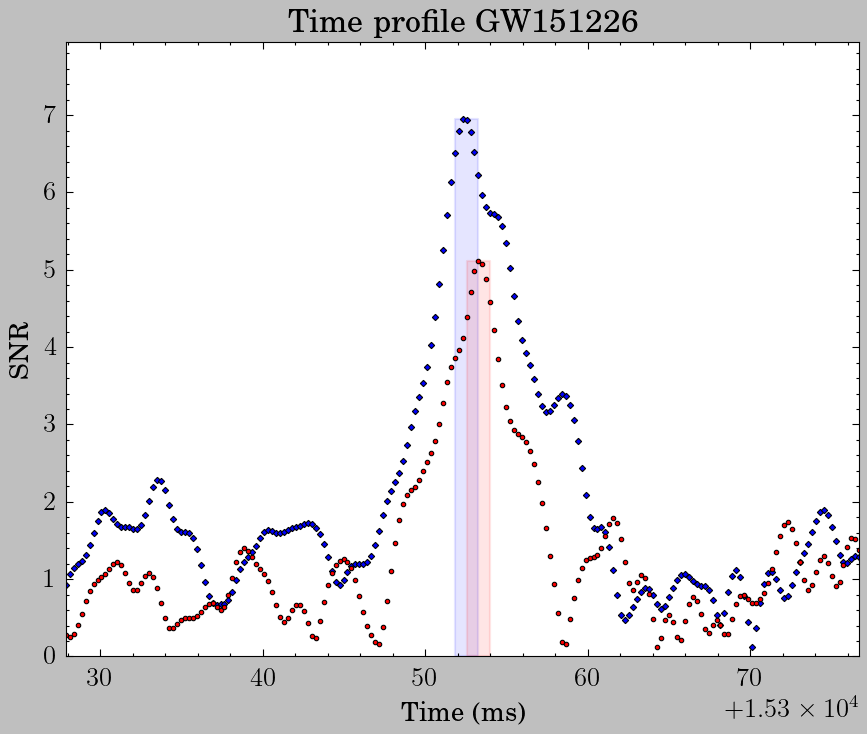

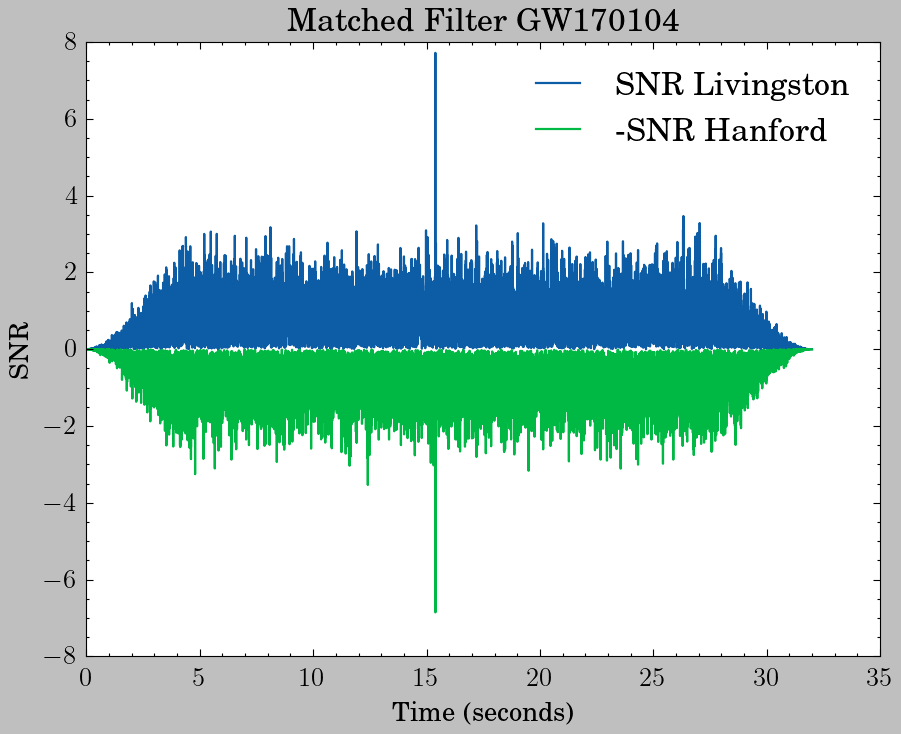

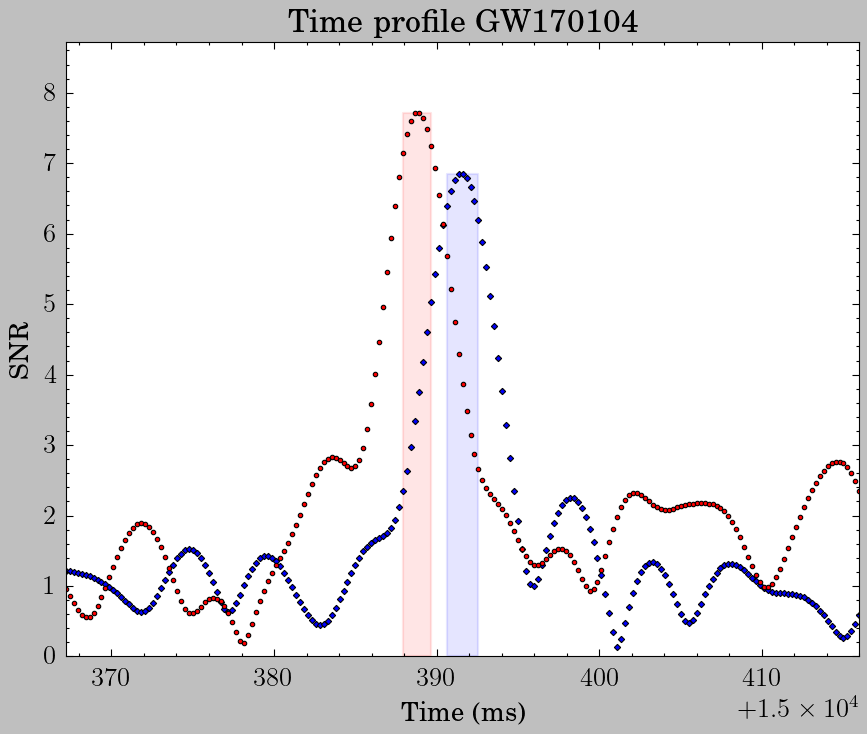

In [261]:
for e in list(event_codes)[1:]:
    event = json.load(open(event_file, "r"))[e]

    print("-"*20, f"EVENT {e}","-"*20)
    sL, dtL, utcL = read_file(dat_fold + event['fn_L1'])
    sH, dtH, utcH = read_file(dat_fold + event['fn_H1'])
    tp, tx = read_template(dat_fold + event['fn_template'])

    time = dtL *len(sH)
    df = 1/time
    f = np.arange(len(sL))*df
    f[0]=0.5*f[1]
    t = dtL * np.arange(len(sH))

    PSsL = np.abs(np.fft.fft(sL))**2
    PSsH = np.abs(np.fft.fft(sH))**2
    PStp = np.abs(np.fft.fft(tp))**2

    win = sig.tukey(len(tp), alpha = .3)

    width = 30
    # strain
    PSsL_win = np.abs(np.fft.fft(sL * win)**2)
    PSsL_smooth = smooth_vector(PSsL_win, width)


    PSsH_win = np.abs(np.fft.fft(sH * win)**2)
    PSsH_smooth = smooth_vector(PSsH_win, width)

    # template
    PStp_win = np.abs(np.fft.fft(tp * win)**2)
    PStp_smooth = smooth_vector(PStp_win, width)


    NL_inv = 1/PSsL_smooth
    NH_inv = 1/PSsH_smooth

    NH_inv[f>1650] = 0
    NL_inv[f>1650] = 0

    NH_inv[f<15] = 0
    NL_inv[f<15] = 0

    FH_white = np.sqrt(NH_inv)* np.fft.fft(sH*win)
    FL_white = np.sqrt(NL_inv)* np.fft.fft(sL*win)
    FL_tp_white = np.sqrt(NL_inv)*np.fft.fft(tp*win) 
    FH_tp_white = np.sqrt(NH_inv)*np.fft.fft(tp*win) 

    sigL = np.fft.ifft(FL_tp_white * np.conj(FL_white))
    sigH = np.fft.ifft(FH_tp_white * np.conj(FH_white))

    varL = np.abs(np.fft.ifft(FL_tp_white * FL_tp_white.conjugate()))
    varH = np.abs(np.fft.ifft(FH_tp_white * FH_tp_white.conjugate()))

    noiseL = np.mean(np.sqrt(varL))
    noiseH = np.mean(np.sqrt(varH))
    noiseC = np.sqrt(noiseL**2+noiseH**2)

    print("Noise for Livingston detector: ".ljust(30), noiseL)
    print("Noise for Livingston detector: ".ljust(30), noiseH)
    print("Combined noise: ".ljust(30), noiseC)

    normH = np.std(sigH[200:-200])
    normL = np.std(sigL[200:-200])

    snrH = np.fft.fftshift(np.abs(sigH/normH))
    snrL = np.fft.fftshift(np.abs(sigL/normL))

    snrC = np.sqrt(snrH.max()**2 + snrL.max()**2)

    plt.figure()
    print("Max SNR for Livingston detector: ".ljust(30), snrL.max())
    print("Max SNR for Livingston detector: ".ljust(30), snrH.max())
    print("Combined SNR: ".ljust(30), snrC)
    plt.title(f"Matched Filter {e}")
    plt.plot(t, snrL, label = "SNR Livingston")
    plt.plot(t, -snrH, label = "-SNR Hanford")
    plt.xlabel('Time (seconds)')
    plt.ylabel('SNR')
    plt.legend()


    AsnrH = np.fft.fftshift(np.abs(sigH/noiseH))
    AsnrL = np.fft.fftshift(np.abs(sigL/noiseL))
    AsnrC = np.sqrt(AsnrH.max()**2 + AsnrL.max()**2)

    print("--"*20, "analytical", "--"*20)
    print("Max Analytical SNR for Livingston detector: ".ljust(50), AsnrL.max())
    print("Max Analytical SNR for Hanford detector: ".ljust(50), AsnrH.max())
    print("Combined Analytical SNR: ".ljust(50), AsnrC)

    print("--"*20, "computed", "--"*20)
    print("Max SNR for Livingston detector: ".ljust(50), snrL.max())
    print("Max SNR for Livingston detector: ".ljust(50), snrH.max())
    print("Combined SNR: ".ljust(50), snrC)

    print("--"*20, "ratio", "--"*20)
    print("Analytic vs. Numerical -- Livingston: ".ljust(50), AsnrL.max()/snrL.max())
    print("Analytic vs. Numerical -- Hanford: ".ljust(50), AsnrH.max()/snrH.max())
    print("Analytic vs. Numerical -- Combined SNR: ".ljust(50), AsnrC/ snrC)
    idx_half = np.argwhere(np.cumsum(np.abs(FH_tp_white))/np.sum(np.abs(FH_tp_white))>.5).flatten().min()
    print("\nHalf-intensity frequency is:".ljust(30), f"{f[idx_half]:.0f}", "Hz")


    plt.figure()
    plt.plot(t*1e3, snrH,'bD', ms = 2 , label = "Livingston")
    plt.plot(t*1e3, snrL,'ro', ms =2 , label = 'Hanford')

    tmaxH = t[np.argmax(snrH)]
    tmaxL = t[np.argmax(snrL)]

    binH = np.argwhere(np.abs(snrH - snrH.max())<1)
    binL = np.argwhere(np.abs(snrL - snrL.max())<1)

    tleftH = t[np.min(binH)]
    trightH = t[np.max(binH)]
    tleftL = t[np.min(binL)]
    trightL = t[np.max(binL)]

    etH = (trightH-tleftH)/2
    etL = (trightL-tleftL)/2

    edt = np.sqrt(etH**2 + etL**2)
    dt = np.abs(tmaxH - tmaxL)
    
    plt.title(f"Time profile {e}")
    plt.axis([(tmaxH-100*dtH)*1e3, (tmaxH+100*dtH)*1e3, 0, np.max([snrH.max(), snrL.max()])+1])
    plt.fill_between(t*1e3 , 0, snrH.max(),where=(t<trightH) & (t>tleftH) ,color='b', alpha = .1)
    plt.fill_between(t*1e3 , 0, snrL.max(),where=(t<trightL) & (t>tleftL) ,color='r', alpha = .1)
    plt.xlabel("Time (ms)")
    plt.ylabel("SNR")

    print("\nTime difference is :".ljust(30), f"{dt*1e3:.1f} +/- {edt*1e3:.1f} ms")
    print("\n"*5)